# Deep Reversi AI

The game is not

In [1]:
%load_ext blackcellmagic

## Imports

In [2]:
import numpy as np
import abc
from typing import Final
from scipy.ndimage import binary_dilation
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from abc import ABC

## Constants

In [3]:
ENEMY: Final[int] = -1
PLAYER: Final[int] = 1
BOARD_SIZE: Final[int] = 8

In [4]:
DIRECTIONS: Final[np.ndarray] = np.array(
    [[i, j] for i in range(-1, 2) for j in range(-1, 2) if j != 0 or i != 0], dtype=int
)
DIRECTIONS

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

## Creating new boards

In [5]:
def get_new_games(number_of_games: int):
    empty = np.zeros([number_of_games, BOARD_SIZE, BOARD_SIZE], dtype=int)
    empty[:, 3:5, 3:5] = np.array([[-1, 1], [1, -1]])
    return empty


get_new_games(1)[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [6]:
test_number_of_games = 3
assert get_new_games(test_number_of_games).shape == (
    test_number_of_games,
    BOARD_SIZE,
    BOARD_SIZE,
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=1),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=2),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
assert np.all(get_new_games(test_number_of_games)[:, 3:4, 3:4] != 0)
del test_number_of_games

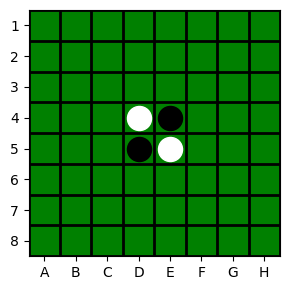

In [7]:
def plot_othello_board(board, ax=None):
    size = 3
    plot_all = False
    if ax is None:
        plot_all = True
        fig, ax = plt.subplots(figsize=(size, size))

    ax.set_facecolor("green")
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if board[i, j] == -1:
                color = "white"
            elif board[i, j] == 1:
                color = "black"
            else:
                continue
            ax.scatter(j, i, s=300 if plot_all else 150, c=color)
    for i in range(-1, 8):
        ax.axhline(i + 0.5, color="black", lw=2)
        ax.axvline(i + 0.5, color="black", lw=2)
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(7.5, -0.5)
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(list("ABCDEFGH"))
    ax.set_yticks(np.arange(8))
    ax.set_yticklabels(list("12345678"))
    if plot_all:
        plt.tight_layout()
        plt.show()


plot_othello_board(get_new_games(1)[0])

In [8]:
def plot_othello_boards(boards: np.ndarray) -> None:
    assert boards.shape[0] < 70
    plots_per_row = 4
    rows = int(np.ceil(boards.shape[0] / plots_per_row))
    fig, axs = plt.subplots(rows, plots_per_row, figsize=(12, 3 * rows))
    for game_index, ax in enumerate(axs.flatten()):
        if game_index >= boards.shape[0]:
            fig.delaxes(ax)
        else:
            plot_othello_board(boards[game_index], ax)
    plt.tight_layout()
    plt.show()

In [9]:
SURROUNDING: Final = np.array([[[1, 1, 1], [1, 0, 1], [1, 1, 1]]])
SURROUNDING

array([[[1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]]])

In [10]:
def recursive_steps(_array, rec_direction, rec_position, step_one=True) -> bool:
    rec_position = rec_position + rec_direction
    if np.any((rec_position >= BOARD_SIZE) | (rec_position < 0)):
        return False
    next_field = _array[tuple(rec_position.tolist())]
    if next_field == 0:
        return False
    if next_field == -1:
        return recursive_steps(_array, rec_direction, rec_position, step_one=False)
    if next_field == 1:
        return not step_one


def get_possible_turns(boards: np.ndarray) -> np.ndarray:
    try:
        _poss_turns = boards == 0
        _poss_turns &= binary_dilation(boards == -1, SURROUNDING)
    except RuntimeError as err:
        print(boards)
        print(boards == -1)
        print("err")
        raise err
    for game in range(boards.shape[0]):
        for idx in range(BOARD_SIZE):
            for idy in range(BOARD_SIZE):

                position = idx, idy
                if _poss_turns[game, idx, idy]:
                    _poss_turns[game, idx, idy] = any(
                        recursive_steps(boards[game, :, :], direction, position)
                        for direction in DIRECTIONS
                    )
    return _poss_turns


# %timeit get_possible_turns(get_new_games(10))
# %timeit get_possible_turns(get_new_games(100))
get_possible_turns(get_new_games(3))[:1]

array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])

In [11]:
def evaluate_boards(array: np.ndarray):
    return np.sum(array == 1, axis=(1, 2)), np.sum(array == -1, axis=(1, 2))


evaluate_boards(get_new_games(3))

(array([2, 2, 2]), array([2, 2, 2]))

In [12]:
def move_possible(board: np.ndarray, move: np.ndarray) -> bool:
    if np.all(move == -1):
        return not np.any(get_possible_turns(np.reshape(board, (1, 8, 8))))
    return any(
        recursive_steps(board[:, :], direction, move) for direction in DIRECTIONS
    )


assert move_possible(get_new_games(1)[0], np.array([2, 3])) is True
assert move_possible(get_new_games(1)[0], np.array([3, 2])) is True
assert move_possible(get_new_games(1)[0], np.array([2, 2])) is False
assert move_possible(np.zeros((8, 8)), np.array([3, 2])) is False
assert move_possible(np.ones((8, 8)) * 1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * -1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * 0, np.array([-1, -1])) is True

In [13]:
def moves_possible(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    arr_moves_possible = np.zeros(boards.shape[0], dtype=bool)
    for game in range(boards.shape[0]):
        if np.all(moves[game] == -1):
            try:
                arr_moves_possible[game] = not np.any(
                    get_possible_turns(np.reshape(boards[game], (1, 8, 8)))
                )
            except Exception as err:
                print(test)
                raise err
        else:
            arr_moves_possible[game] = any(
                recursive_steps(boards[game, :, :], direction, moves[game])
                for direction in DIRECTIONS
            )
    return arr_moves_possible


np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * 1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 3], [3, 2], [3, 2]])),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 2], [1, 1], [0, 0]])),
    np.array([False] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * -1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.zeros((3, 8, 8)), np.array([[-1, -1]] * 3)), np.array([True] * 3)
)

In [14]:
class InvalidTurn(ValueError):
    pass


def do_moves(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    def _do_directional_move(
        board: np.ndarray, rec_move: np.ndarray, rev_direction, step_one=True
    ) -> bool:
        rec_position = rec_move + rev_direction
        if np.any((rec_position >= 8) | (rec_position < 0)):
            return False
        next_field = board[tuple(rec_position.tolist())]
        if next_field == 0:
            return False
        if next_field == 1:
            return not step_one
        if next_field == -1:
            if _do_directional_move(board, rec_position, rev_direction, step_one=False):
                board[tuple(rec_position.tolist())] = 1
                return True
            return False

    def _do_move(_board: np.ndarray, move: np.ndarray) -> None:
        if np.all(move == -1):
            return
        if _board[tuple(move.tolist())] != 0:
            raise InvalidTurn
        action = False
        for direction in DIRECTIONS:
            if _do_directional_move(_board, move, direction):
                action = True
        if not action:
            raise InvalidTurn()
        _board[tuple(move.tolist())] = 1

    boards = boards.copy()
    for game in range(boards.shape[0]):
        _do_move(boards[game], moves[game])
    return boards


boards = get_new_games(10)
do_moves(boards, np.array([[2, 3]] * 10))[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [15]:
class GamePolicy(ABC):

    IMPOSSIBLE: np.ndarray = np.array([-1, -1], dtype=int)

    @abc.abstractproperty
    def policy_name(self) -> str:
        raise NotImplementedError()

    @abc.abstractmethod
    def internal_policy(self, boards: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    def get_policy(self, boards: np.ndarray) -> np.ndarray:
        policies = self.internal_policy(boards)
        possible_turns = get_possible_turns(boards)
        poss_turns_debug = possible_turns[0]
        policies[possible_turns == False] = -1.0
        max_indices = [
            np.unravel_index(policy.argmax(), policy.shape) for policy in policies
        ]
        policy_vector = np.array(max_indices)
        # todo check if no turn is possible and return [-1, -1]
        a1 = np.all(policy_vector[:] == 0, 1)
        a2 = policies[:, 0, 0] == -1.0
        no_turn_possible = np.all(policy_vector == 0, 1) & (policies[:, 0, 0] == -1.0)
        if np.any(no_turn_possible):
            cases = np.where(no_turn_possible)
            print(cases)
            print("Test")

        policy_vector[no_turn_possible] = GamePolicy.IMPOSSIBLE
        return policy_vector

In [16]:
class RandomPolicy(GamePolicy):
    @property
    def policy_name(self) -> str:
        return "random"

    def internal_policy(self, boards: np.ndarray) -> np.ndarray:
        random_values = np.random.rand(*boards.shape)
        return random_values
        # return np.argmax(random_values, (1, 2))


rndpolicy = RandomPolicy()
assert rndpolicy.policy_name == "random"

In [17]:
def single_turn(current_boards: np, policy: GamePolicy) -> np.ndarray:
    policy_results = policy.get_policy(current_boards)
    poss = moves_possible(current_boards, policy_results)
    if not np.all(poss):
        false_values = np.where(poss == False)
        bad_boards = current_boards[false_values]
        bad_policy = policy_results[false_values]
        print("test")

    try:
        assert np.all(moves_possible(current_boards, policy_results)), (
            current_boards[(moves_possible(current_boards, policy_results) == False)],
            policy_results[(moves_possible(current_boards, policy_results) == False)],
            np.where(moves_possible(current_boards, policy_results) == False),
        )
    except AssertionError as err:
        raise err

    return do_moves(current_boards, policy_results)


single_turn(get_new_games(10), RandomPolicy())[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [18]:
def simulate_game(
    nr_of_games: int,
    policies: tuple[GamePolicy, GamePolicy],
) -> np.ndarray:
    history_stack = np.zeros((70, nr_of_games, 8, 8))
    current_boards = get_new_games(nr_of_games)
    index_counter = 0
    for i in range(60):
        policy_index = i % 2
        policy = policies[policy_index]
        if policy_index == 0:
            current_boards = current_boards * -1
        try:
            current_boards = single_turn(current_boards, policy)
        except RuntimeError as err:
            print("Err")
            print(history_stack)
            raise err
        if policy_index == 0:
            current_boards = current_boards * -1

        history_stack[index_counter] = current_boards
        index_counter += 1
    return history_stack


simulate_game(10, (RandomPolicy(), RandomPolicy()))

(array([1], dtype=int64),)
Test
(array([1], dtype=int64),)
Test
(array([0, 4, 5, 7, 8], dtype=int64),)
Test


array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.

In [19]:
arr = np.array(
    [
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 0, -1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 0, -1, 1, 0, 0, 0],
            [0, 0, -1, -1, -1, 0, 0, 0],
            [0, 0, 1, -1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, -1, -1, 0],
            [0, 0, 1, 0, -1, 0, 0, 0],
            [0, 0, 0, 1, -1, 0, 0, 0],
            [0, 0, 0, -1, 1, -1, -1, 0],
            [0, 0, -1, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
    ]
)
arr

array([[[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  0, -1,  0,  0],
        [ 0,  0,  1,  1,  1,  1,  0,  0],
        [ 0,  0,  0, -1,  1,  0,  0,  0],
        [ 0,  0, -1, -1, -1,  0,  0,  0],
        [ 0,  0,  1, -1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -1, -1, -1,  0],
        [ 0,  0,  1,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  1, -1,  0,  0,  0],
        [ 0,  0,  0, -1,  1, -1, -1,  0],
        [ 0,  0, -1,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]]])

In [20]:
get_possible_turns(arr)

array([[[False, False,  True,  True,  True,  True,  True, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False,  True, False, False,  True,  True, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False,  True, False,  True, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False,  True, False,  True],
        [False, False,  True, False, False, False, False,  True],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        

In [21]:
moves_possible(arr, RandomPolicy().get_policy(arr))

array([ True,  True])

In [22]:
RandomPolicy().get_policy(arr)

array([[0, 4],
       [4, 7]], dtype=int64)

In [ ]:
import numpy as np


def create_test_game():
    test_array = [
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 0, 2, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 0, 2, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 1, 1, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 0, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 1, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 0, 2, 2, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [0, 1, 1, 1, 1, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 2, 2, 0, 0],
            [2, 2, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 1, 1, 1, 0],
            [2, 2, 2, 2, 2, 2, 0, 0],
            [0, 2, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 2, 0, 0],
            [0, 0, 0, 1, 1, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 0, 0, 0],
            [0, 0, 0, 2, 2, 2, 0, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 2, 1, 0, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 2, 2, 2, 0],
            [0, 0, 0, 2, 2, 2, 1, 0],
            [2, 2, 2, 1, 2, 2, 0, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 2, 1, 1, 0],
            [2, 2, 2, 1, 1, 1, 1, 0],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 2, 1, 2, 0],
            [2, 2, 2, 2, 2, 2, 2, 2],
            [0, 2, 0, 1, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 2, 1, 0, 1, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 1, 1, 2, 0],
            [2, 2, 2, 2, 1, 2, 2, 2],
            [0, 2, 0, 1, 1, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 2, 0, 0, 0],
            [0, 0, 2, 2, 0, 2, 0, 0],
            [0, 0, 0, 2, 1, 2, 2, 0],
            [0, 0, 0, 2, 1, 1, 2, 0],
            [2, 2, 2, 2, 1, 2, 2, 2],
            [0, 2, 0, 1, 1, 2, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ],
    ]
    test_array = np.array(test_array)

    # swapp 2 by one. 2 was only there for homogenous formating and easier readability while coading.
    test_array[test_array == 2] = -1
    assert np.all(
        np.count_nonzero(test_array, axis=(1, 2))
        == np.arange(4, 4 + test_array.shape[0])
    )

    # validated that only one stone is added per turn
    zero_array = test_array == 0
    diff = zero_array != np.roll(zero_array, 1, axis=0)
    turns = np.where(diff[1:])
    arr = np.array(turns)[0]
    assert len(arr) == len(set(arr))

    return test_array

In [ ]:
plot_othello_boards(create_test_game()[-3:])

In [ ]:
array = create_test_game()